In [54]:
# importing a packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from tensorflow.keras import layers, models, optimizers, losses, callbacks,\
                             regularizers
warnings.filterwarnings('ignore')

In [55]:
# Loading a data from the CSV file
netflixStockDF = pd.read_csv('NFLX.csv')
netflixStockDF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [56]:
# Calculate 5- day moving average if the value are NaN the fill it using next valid value
netflixStockDF['MA_5'] = netflixStockDF['Close'].rolling(window = 5).mean().fillna(method='bfill')

# Calculate 20 - day moving average if the value are NaN the fill it using next valid value
netflixStockDF['MA_20'] = netflixStockDF['Close'].rolling(window = 20).mean().fillna(method='bfill')

# removing missing values from the dataframe
netflixStockDF.fillna(method='bfill') 

netflixStockDF

,Date,Open,High,Low,Close,Adj Close,Volume,MA_5,MA_20
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,256.822000,276.568499
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,256.822000,276.568499
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,256.822000,276.568499
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,256.822000,276.568499
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,256.822000,276.568499
...,...,...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,384.864007,487.853500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,403.006006,480.841501
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,416.962006,472.758000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200,420.742004,464.661999


In [57]:
netflixStockDF.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
MA_5         float64
MA_20        float64
dtype: object

In [58]:
def preProcessing(dataframe):
        '''
        Preprocceses a stock price dataframe by extracting date features,
        reordering columns. Rounding numerical vlaues. this function will return a preprocessed 'Dataframe'.
        '''
        # Converting a date column to datetime columns  
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        
        # Extrating a Number of year, month, week and day
        dataframe['Year']  = dataframe['Date'].dt.year
        dataframe['Month'] = dataframe['Date'].dt.month
        dataframe['Week']  = dataframe['Date'].dt.day_of_week
        dataframe['Day']  = dataframe['Date'].dt.day
            
        # Reordering a columns values 
        dataframe = dataframe[['Year', 'Month', 'Week','Day','Open','High','Low', 'Close','Volume', 'MA_5', 'MA_20']]
        
        # Applying a decimal precision to decimal or floting datatype columns.
        for col in dataframe[['Open','High', 'Low', 'Close', 'MA_5', 'MA_20']]:
            dataframe[col] = dataframe[col].apply(lambda x: round(x,2))
        return dataframe

In [59]:
def visualizaiton(ytest, ypred):
    plt.figure(figsize=(14,6))
    plt.scatter(ytest.values, ypred, alpha=0.5)
    plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'k--', linewidth=2)
    plt.xlabel('Actual Closing Prices')
    plt.ylabel('Predicated Closing Prices')
    plt.title('Scatter Plot: Actual vs. Predicted')
    plt.grid(True)
    plt.show()

In [60]:
netflixStockDF = preProcessing(netflixStockDF)
netflixStockDF

,Year,Month,Week,Day,Open,High,Low,Close,Volume,MA_5,MA_20
0,2018,2,0,5,262.00,267.90,250.03,254.26,11896100,256.82,276.57
1,2018,2,1,6,247.70,266.70,245.00,265.72,12595800,256.82,276.57
2,2018,2,2,7,266.58,272.45,264.33,264.56,8981500,256.82,276.57
3,2018,2,3,8,267.08,267.62,250.00,250.10,9306700,256.82,276.57
4,2018,2,4,9,253.85,255.80,236.11,249.47,16906900,256.82,276.57
...,...,...,...,...,...,...,...,...,...,...,...
1004,2022,1,0,31,401.97,427.70,398.20,427.14,20047500,384.86,487.85
1005,2022,2,1,1,432.96,458.48,425.54,457.13,22542300,403.01,480.84
1006,2022,2,2,2,448.25,451.98,426.48,429.48,14346000,416.96,472.76
1007,2022,2,3,3,421.44,429.26,404.28,405.60,9905200,420.74,464.66


In [61]:
# Summary of numerical Columns
netflixStockDF[['Open','High','Low', 'Close','Volume']].describe()

,Open,High,Low,Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320704,412.374044,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,5.465535e+06
min,233.920000,250.650000,231.230000,233.880000,1.144000e+06
25%,331.490000,336.300000,326.000000,331.620000,4.091900e+06
50%,377.770000,383.010000,370.880000,378.670000,5.934500e+06
75%,509.130000,515.630000,502.530000,509.080000,9.322400e+06
max,692.350000,700.990000,686.090000,691.690000,5.890430e+07


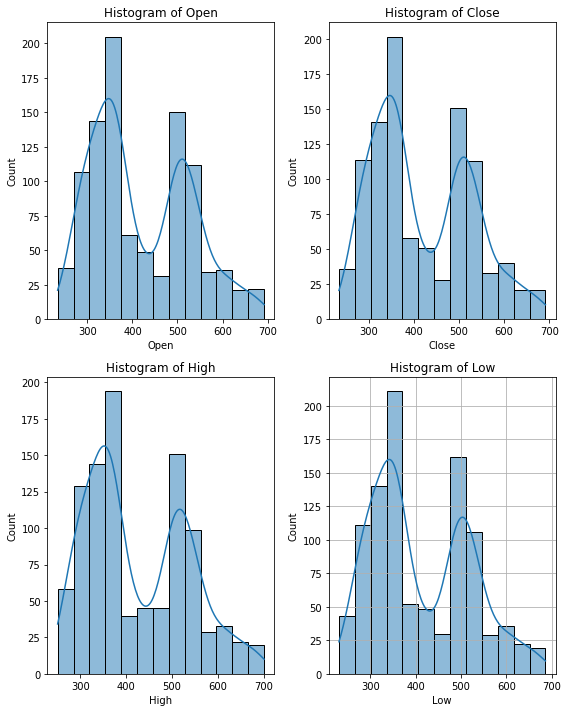

In [62]:
# Histogram plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,10))

# extrating a columns
netflixStockDF_col = ['Open','Close','High','Low']
for i, (colm, axes) in enumerate(zip(netflixStockDF_col, axes.flatten())):
  sns.histplot(data=netflixStockDF, x=colm, ax=axes, kde=True)
  axes.set_title(f'Histogram of {colm}')
plt.grid(True)
plt.tight_layout()

In [122]:
# Splitting a data into training and testing
features   = ['Year', 'Month', 'Week','Day','Open','High','Low','Volume', 'MA_5', 'MA_20'] 
target_col = 'Close'

x = netflixStockDF[features] 
y = netflixStockDF[target_col]

#Splitting the data into training and testing sets (70% train, 30% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print('X_train shape :' ,x_train.shape)
print('X_test  shape :' ,x_test.shape)
print('Y_train shape :' ,y_train.shape)
print('Y_test  shape :' ,y_test.shape)


X_train shape : (706, 10)
X_test  shape : (303, 10)
Y_train shape : (706,)
Y_test  shape : (303,)


In [64]:
scaler = StandardScaler()

x_train_scaler = scaler.fit_transform(x_train)
x_test_scaler  = scaler.fit_transform(x_test)

In [65]:
# Training Randomforestregressor model
rm_model = RandomForestRegressor(n_estimators=200, random_state=40)
rm_model.fit(x_train_scaler, y_train)

RandomForestRegressor(n_estimators=200, random_state=40)

Mean Absolute Error: 12.374512541254067 
Mean Squared Error : 176.93212345659896 
R-Squared          : 0.9844527936799466  


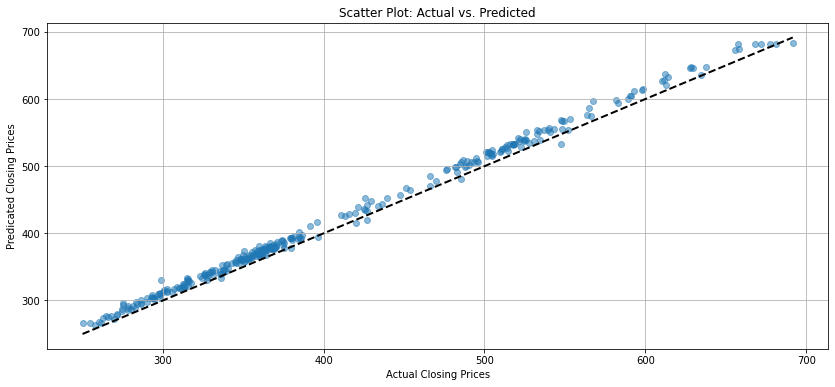

In [66]:
# Making prediction
y_pred = rm_model.predict(x_test_scaler)

# Evaluating the Model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Absolute Error: {mae} ")
print(f"Mean Squared Error : {mse} ")
print(f"R-Squared          : {r2}  ")

visualizaiton(y_test, y_pred)

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators'      : [500, 700, 900], #old_para: [200, 300, 500],
    'max_depth'         : [None, 20, 30],  #old_para: [10, 20, 30],
    'min_samples_split' : [10, 15, 20],    #old_para: [5,10, 15]
}

grid_search = GridSearchCV(estimator=rm_model, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
best_model

RandomForestRegressor(min_samples_split=10, n_estimators=700, random_state=40)

Mean Absolute Error: 3.7649918750109124 
Mean Squared Error : 27.958245006166887 
R-Squared          : 0.9975432804684329  


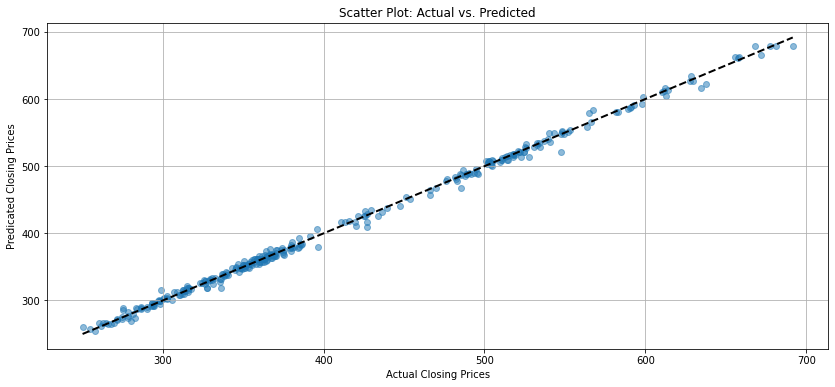

In [68]:
y_test_pred = best_model.predict(x_test)

# Evaluating the Model
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)


print(f"Mean Absolute Error: {mae} ")
print(f"Mean Squared Error : {mse} ")
print(f"R-Squared          : {r2}  ")

visualizaiton(y_test, y_test_pred)

In [113]:
def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

# Set the number of timesteps
timesteps = 7

# Reshape your data
x = netflixStockDF[['Open','High','Low','Volume', 'MA_5', 'MA_20']].values
y = netflixStockDF['Close'].values

# Create sequences
x, y = create_sequences(x, timesteps)

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print('X_train shape :' ,x_train.shape)
print('X_test  shape :' ,x_test.shape)
print('Y_train shape :' ,y_train.shape)
print('Y_test  shape :' ,y_test.shape)

X_train shape : (701, 7, 6)
X_test  shape : (301, 7, 6)
Y_train shape : (701, 6)
Y_test  shape : (301, 6)


In [114]:
# Define the number of timesteps and features
timesteps = 7 # Number of previous days you consider to predict next day stock price
features = x_train.shape[2] # Number of features example. Open, High, Low, Close, Volume

# CNN Input Layer
input_Layer = layers.Input(shape = (timesteps, features), name='Input Shape')

# CNN Layer 1
conv_1        = Conv1D(filters=64, kernel_size=2, activation='relu', name = 'Conv_1')(input_Layer)
max_pooling_1 = MaxPool1D(pool_size=2, name = 'Maxpooling_1')(conv_1)
drop_1        = Dropout(0.1)(max_pooling_1) 

# CNN Layer 2
conv_2        = Conv1D(filters=128, kernel_size=2, activation='relu', name = 'Conv_2')(drop_1)
max_pooling_2 = MaxPool1D(pool_size=2, name = 'Maxpooling_2')(conv_2)
drop_2        = Dropout(0.1)(max_pooling_2)

flatten = Flatten(name='flatten')(drop_2)
den_1 = Dense(1, activation='relu', name='fc_1')(flatten)

# Defining Models
cnn_model = models.Model(inputs = input_Layer, outputs=den_1, name = 'CNN_model')

# Summary of CNN Model
cnn_model.summary()


Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Shape (InputLayer)    [(None, 7, 6)]            0         
                                                                 
 Conv_1 (Conv1D)             (None, 6, 64)             832       
                                                                 
 Maxpooling_1 (MaxPooling1D  (None, 3, 64)             0         
 )                                                               
                                                                 
 dropout_16 (Dropout)        (None, 3, 64)             0         
                                                                 
 Conv_2 (Conv1D)             (None, 2, 128)            16512     
                                                                 
 Maxpooling_2 (MaxPooling1D  (None, 1, 128)            0         
 )                                                       

In [115]:
cnn_model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])
history = cnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/20
22/22 [==============================] - 1s 8ms/step - loss: 13488654123008.0000 - mae: 1971569.0000 - val_loss: 13322417078272.0000 - val_mae: 1455449.5000
Epoch 2/20
22/22 [==============================] - 0s 3ms/step - loss: 13119717900288.0000 - mae: 1931266.2500 - val_loss: 12426935271424.0000 - val_mae: 2101178.5000
Epoch 3/20
22/22 [==============================] - 0s 4ms/step - loss: 12948052377600.0000 - mae: 2084149.5000 - val_loss: 12392054390784.0000 - val_mae: 1982919.2500
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 12838588383232.0000 - mae: 2040075.0000 - val_loss: 12606139006976.0000 - val_mae: 1744169.0000
Epoch 5/20
22/22 [==============================] - 0s 3ms/step - loss: 12770952085504.0000 - mae: 2067609.2500 - val_loss: 12481330151424.0000 - val_mae: 1815187.3750
Epoch 6/20
22/22 [==============================] - 0s 3ms/step - loss: 12805894832128.0000 - mae: 2053221.1250 - val_loss: 12390463700992.0000 - val_mae: 18986

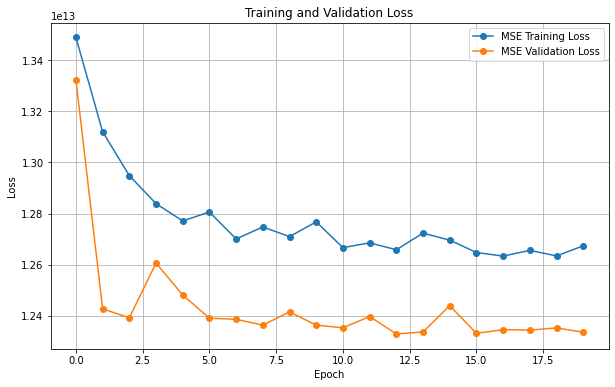

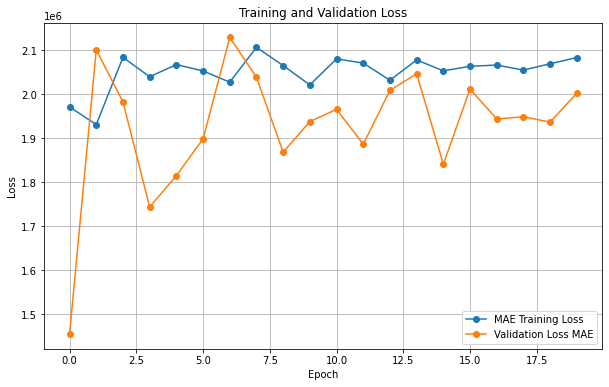

In [116]:
loss = history.history['loss']
val_loss = history.history['val_loss']

cnn_mae = history.history['mae']
val_mae = history.history['val_mae']

# Plotting for the modle graph
plt.figure(figsize=(10, 6))
plt.plot(loss, label='MSE Training Loss ', marker='o')
plt.plot(val_loss, label='MSE Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plotting for the modle graph
plt.figure(figsize=(10, 6))
plt.plot(cnn_mae, label='MAE Training Loss', marker='o')
plt.plot(val_mae, label='Validation Loss MAE', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

10/10 [==============================] - 0s 943us/step


Text(0.5, 1.0, 'Orginal Predications VS  Smoothed Predictions')

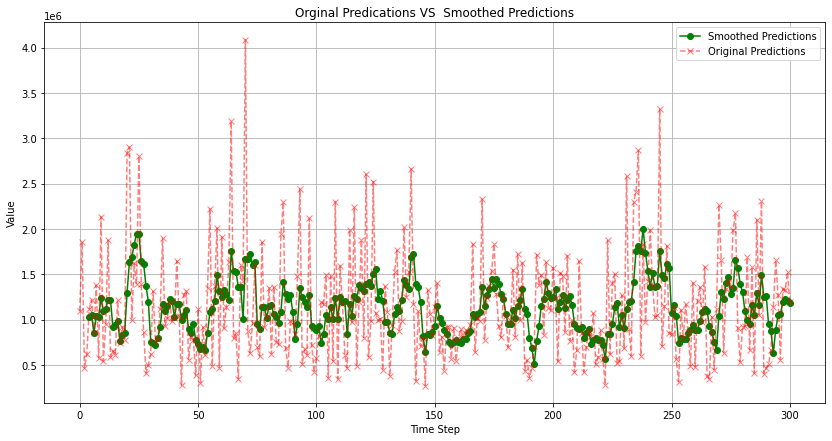

In [121]:
# prediction
pred_x_test = cnn_model.predict(x_test)

plt.figure(figsize=(14, 7))

# Smooth the predictions using a rolling average 
pred_x_test_smooth = pd.Series(pred_x_test.flatten()).rolling(window=5).mean() 
y_test_smooth = pd.Series(y_test.flatten()).rolling(window=5).mean() 
# Plot the smoothed predictions
plt.plot(pred_x_test_smooth, label='Smoothed Predictions', color='green', linestyle='-', marker = 'o')
plt.plot(pred_x_test, label='Original Predictions', color='red', linestyle='--', marker='x', alpha=0.5)
plt.grid(True)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Orginal Predications VS  Smoothed Predictions')  
